In this notebook we examine whether the G3 compartment represents only the walking/paused state of the fly, or whether it contains information about the fine-scale walking speed of the fly as well.

# Classify walking/paused states using G3

Here we fit a logistic regression classifier to predict the walking ('W') or paused ('P') states for each trial with labeled states.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

from aux import make_extended_predictor_matrix
from data import DataLoader


class ClassifierResult(object):
    
    def __init__(self, trial_id, dans, windows, valid, states_pred, states, coefs, clf):
        self.trial_id = trial_id,
        self.dans = dans
        self.windows = windows
        self.valid = valid
        self.states_pred = states_pred
        self.states = states
        self.coefs = coefs
        self.clf = clf
        
        # get number of valid time points
        self.n_valid = valid.sum()
        
        # get fraction of valid time points in walking state
        self.walk_frac = np.sum(states[valid] == 'W') / self.n_valid
        
        # get accuracy (fraction of correctly labeled valid states)
        if states_pred is not None:
            self.acc = np.sum(states_pred[valid] == states[valid]) / self.n_valid
        else:
            self.acc = np.nan
            
            
def classify_states(trial, windows):
    """
    Fit a classifier predicting a trial's paused vs. walking states
    using activity from a set of neural compartments.
    
    :param trial: trial object
    :param dans: list of DAN compartments to use for prediction
    :param windows: dict of windows to use for each predictive dan
        (keys are DAN names, vals are tuples of (start, end) time
            points relative to time point of prediction)
            
    :return: ClassifierResult
    """
    
    try:
        dl = trial.dl
    except:
        trial.dl = DataLoader(trial, vel_filt=None)
        dl = trial.dl
    
    dans = list(windows.keys())
    states = dl.states
    vs = {dan: getattr(dl, dan) for dan in dans}
    
    # make extended dan predictor matrix
    vs_extd = make_extended_predictor_matrix(vs, windows, order=dans)
    
    # make valid mask (not nan predictors and not ambiguous state)
    valid = np.all(~np.isnan(vs_extd), axis=1) & (states != 'A')
    
    if len(set(states[valid])) == 2:
        # at least two states
        
        # fit classifier
        clf = LogisticRegression(n_jobs=-1)
        clf.fit(vs_extd[valid], states[valid])
        
        # make state predictions
        states_pred = np.repeat('', len(states))
        states_pred[valid] = clf.predict(vs_extd[valid])
        
        # get coefficients
        window_lens = [windows[d][1] - windows[d][0] for d in dans]
        splits = np.split(clf.coef_[0], np.cumsum(window_lens)[:-1])
        
        coefs = {d: s for d, s in zip(dans, splits)}
        
    else:
        # fewer than two states
        clf = None
        states_pred = None
        coefs = None
        
    result = ClassifierResult(
        trial_id=trial.id, dans=dans, windows=windows, valid=valid,
        states_pred=states_pred, states=states, coefs=coefs, clf=clf)
    
    return result

# Predict walking speed during walking states using G3

In [2]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]
WINDOWS = {'G3S': (-1, 2)}

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT)
session.close()

results = [classify_states(trial, WINDOWS) for trial in trials]

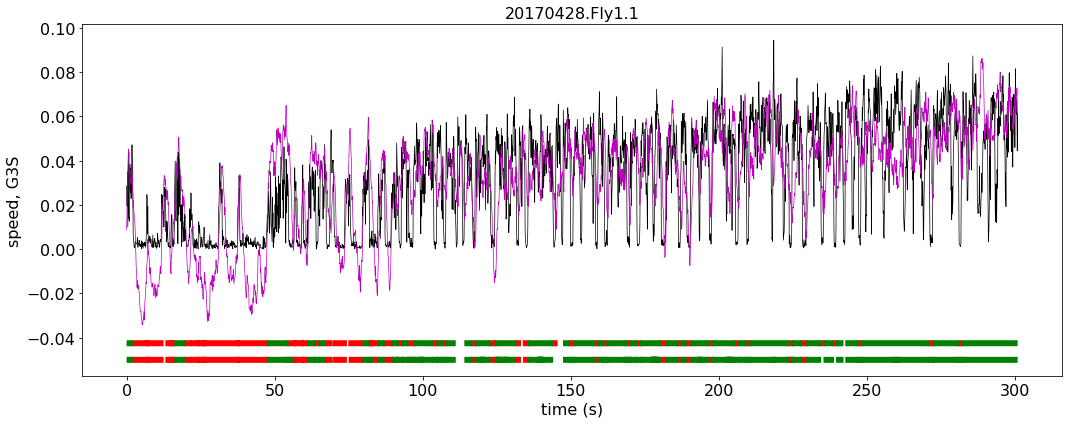

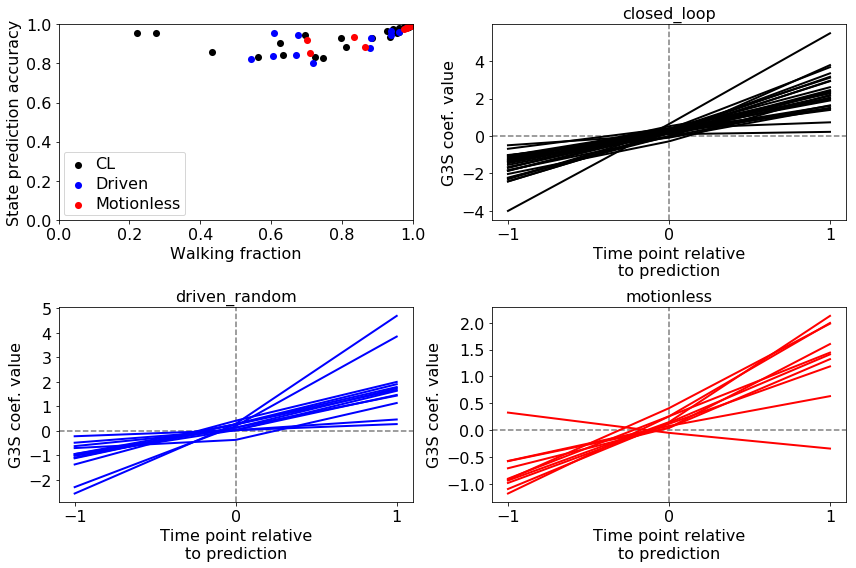

In [4]:
from plot import set_font_size

EXAMPLE = '20170428.Fly1.1'
LINE_YS = [-0.0425, -0.05]
LW = 6

# plot example trial's walking speed, G3S, true state labels, and predicted state labels
trial_idx = [trial.name for trial in trials].index(EXAMPLE)
trial_ex = list(trials)[trial_idx]
res_ex = results[trial_idx]

fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True)

try:
    trial_ex.dl
except:
    trial_ex.dl = DataLoader(trial_ex, vel_filt=None)

ts = trial_ex.dl.timestamp_gcamp
speed = trial_ex.dl.speed
G3S = trial_ex.dl.G3S

# normalize G3S to be plottable atop speed
G3S -= G3S.mean()
G3S /= G3S.std()
G3S *= speed.std()
G3S += speed.mean()

ax.plot(ts, speed, color='k', lw=0.7)
ax.plot(ts, G3S, color='m', lw=0.7)

# plot true state labels, predicted state labels, and 
states_p = np.repeat(np.nan, len(ts))
states_p[res_ex.states == 'P'] = LINE_YS[0]
states_w = np.repeat(np.nan, len(ts))
states_w[res_ex.states == 'W'] = LINE_YS[0]

states_p_pred = np.repeat(np.nan, len(ts))
states_p_pred[res_ex.states_pred == 'P'] = LINE_YS[1]
states_w_pred = np.repeat(np.nan, len(ts))
states_w_pred[res_ex.states_pred == 'W'] = LINE_YS[1]

ax.plot(ts, states_p, lw=LW, color='r')
ax.plot(ts, states_w, lw=LW, color='g')

ax.plot(ts, states_p_pred, lw=LW, color='r')
ax.plot(ts, states_w_pred, lw=LW, color='g')

ax.set_xlabel('time (s)')
ax.set_ylabel('speed, G3S')
ax.set_title(EXAMPLE)

set_font_size(ax, 16)


# plot accuracy vs. fraction of time spent walking, and G3S coefs
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

walk_fracs = np.array([r.walk_frac for r in results])
accs = np.array([r.acc for r in results]).astype(float)

closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
mtnless_mask = [trial.expt == 'motionless' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'motionless': 'r'}

axs[0, 0].scatter(walk_fracs[closed_mask], accs[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
axs[0, 0].scatter(walk_fracs[driven_mask], accs[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
axs[0, 0].scatter(walk_fracs[mtnless_mask], accs[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)

axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_ylim(0, 1)

axs[0, 0].set_xlabel('Walking fraction')
axs[0, 0].set_ylabel('State prediction accuracy')
axs[0, 0].legend(['CL', 'Driven', 'Motionless'], loc='best')

ax_dict = {'closed_loop': axs[0, 1], 'driven_random': axs[1, 0], 'motionless': axs[1, 1]}

for res, trial in zip(results, trials):
    ax = ax_dict[trial.expt]
    c = c_dict[trial.expt]
    
    if res.coefs is not None:
        ax.plot(np.arange(*WINDOWS['G3S']), res.coefs['G3S'], color=c, lw=2)
        
for expt, ax in ax_dict.items():
    ax.axhline(0, color='gray', ls='--', zorder=-1)
    ax.axvline(0, color='gray', ls='--', zorder=-1)
    
    ax.set_xlabel('Time point relative\nto prediction')
    ax.set_ylabel('G3S coef. value')
    
    ax.set_xticks(range(*WINDOWS['G3S']))
    ax.set_title(expt)
    
for ax in axs.flatten():
    set_font_size(ax, 16)

# Predict walking speed during walking epochs using G3S

In [ ]:
class RegressionResult(self, trial_id, dans, window, valid, speeds, speeds_pred, coefs, rgr):
    pass